## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, A new e-commerce web page has been devloped in order to try increasing the number of users who are willing to pay more for the company's product.

The aim is to understand the results of an A/B test, and  help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [42]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [43]:
AB = pd.read_csv('/Users/Abdulaziz/Desktop/ab_data.csv')
AB.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [44]:
AB.shape[0]

294478

c. The number of unique users in the dataset.

In [45]:
AB['user_id'].nunique()

290584

d. The proportion of users converted.

In [46]:
AB['converted'].mean()*100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't match.

In [47]:
AB.query('landing_page == "new_page" and group == "control"').count()[0] + AB.query('landing_page == "old_page" and group == "treatment"').count()[0]

3893

f. Do any of the rows have missing values?

In [48]:
AB.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [49]:
#copying the dataframe
AB2=AB

In [50]:
AB2.drop(AB2.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)
AB2.drop(AB2.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)
AB2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [51]:
# Double Check all of the correct rows were removed - this should be 0
AB2[((AB2['group'] == 'treatment') == (AB2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [52]:
AB2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [53]:
AB2[AB2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [54]:
AB2[AB2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [55]:
AB2.drop(2893, inplace=True)

In [38]:
AB2[AB2.duplicated(['user_id'])]['user_id'].unique()

array([], dtype=int64)

In [57]:
sum(AB2.duplicated())

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [58]:
AB2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [63]:
AB2.query("group == 'control'").converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [62]:
AB2.query("group == 'treatment'").converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [65]:
len(AB2.query("landing_page == 'new_page'")) / AB2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

###### 1-The proportion of individual in the treatment group that converted is 11.8%.
###### 2-The proportion of individual in the control group that converted is 12.03%.
###### 3-The probability that an individual received a new page is roughly 0.5.
###### 4-As the analysis shows the converting rate is a bit similar in both cases so it is important to consider other factors.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

###### Ho : Pold > Pnew

###### Ho: Pold = Pnew

###### H1 : Pold < Pnew

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [72]:
pnew = AB2['converted'].mean()
pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [84]:
pold = AB2['converted'].mean()
pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [106]:
nnew = AB2.query("group == 'treatment'").shape[0]
nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [107]:
nold = AB2.query("group == 'control'").shape[0]
nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [108]:
npconverted = np.random.choice([0, 1], size = nnew, p = [pnew, 1 - pnew])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [109]:
opconverted = np.random.choice([0, 1], size = nold, p = [pold, 1 - pold])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [112]:
p_diff = npconverted.mean() - opconverted.mean()
p_diff

-0.000961423874575873

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [114]:
p_diffs = []

for _ in range(10000):
    npconverted = np.random.choice([0, 1], size = nnew, p = [pnew, 1 - pnew]).mean()
    opconverted = np.random.choice([0, 1], size = nold, p = [pold, 1 - pold]).mean()
    p_diffs.append(npconverted - opconverted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

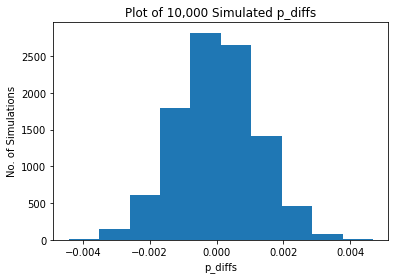

In [116]:
plt.hist(p_diffs);
plt.ylabel('No. of Simulations')
plt.xlabel('p_diffs')
plt.title('Plot of 10,000 Simulated p_diffs');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [119]:
AB2_DI = AB2[AB2['group'] == 'treatment']['converted'].mean() -  AB2[AB2['group'] == 'control']['converted'].mean()
print(AB2_DI)

-0.0015782389853555567


In [120]:
p_diffs = np.array(p_diffs)
(AB2_DI < p_diffs).mean()

0.9051

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

###### -The value calculated is called p-value which is the (probability of getting our statistic or a more extreme value if the null is true). For accepting null hypothesis p-value should be greater than suggested p-value. It can be shown that almost 90% of the population is above the real diffrence which suggested that new-page is not doing significantly better than the old page. So we fail to reject the null hyposthesis as p-value is large.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [122]:
import statsmodels.api as sm
convert_old = AB2.query('landing_page == "old_page" and converted == 1').count()[0]
nold = AB2.query('landing_page =="old_page"').count()[0]
convert_new = AB2.query('landing_page == "new_page" and converted == 1').count()[0]
nnew = AB2.query('landing_page =="new_page"').count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [124]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [nold, nnew], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


In [128]:
from scipy.stats import norm
# Answers how significant our z-score is
print(norm.cdf(z_score))

# Critical value of 95% confidence
print(norm.ppf(1-(0.05/2)))

0.9050583127590245
1.959963984540054


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?


###### Since the z-score of (1.31) less than the critical value of (1.96); there is no statistical evidence to reject the null hypothesis. Furthermore, p-value obtained is agrees with the previous findings in parts  j. and k. which also fails to reject the null hypothesis as it provides evidence of a higher probability of the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

###### Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [163]:
AB2['intercept'] = 1
AB2[['control','ab_page']] = pd.get_dummies(AB2['group'])

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [164]:
logimodel = sm.Logit(AB2['converted'],AB2[['intercept' ,'ab_page ']])
results = logimodel.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [165]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        17:50:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

###### -p-value associated with ab_page is 0.19 which was significantly lower than the one in Part II which was approximately 0.9.
###### -The reason for such a significant difference is because the null and alternative hypothesis differed in each exercise. Because last one is two sided test and in Part II was one sided test.Here we test for not equal in our hypotheses there wad greater than or equal.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

###### - As we have not accounted for any other factors, so it will be a good idea to add some additional factors which may contribute to the outcome. However, we need to take into consideration if there are correlated errors or outliers introduced in the model due to these factors, which will lead to an unreliable result.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [166]:
countries_AB = pd.read_csv('/Users/Abdulaziz/Desktop/countries.csv')
ABN = countries_AB.set_index('user_id').join(AB2.set_index('user_id'), how='inner')
ABN.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page,ab_page
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,1,1


In [167]:
# Finding unique countries in dataset
countries_AB['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [168]:
### Create the necessary dummy variables
ABN[['CA','US','UK']] = pd.get_dummies(ABN['country'])[['CA','US','UK']]

In [169]:
logimodel_countries = sm.Logit(ABN['converted'],ABN[['intercept','US','UK']])
results_c = logimodel_countries.fit()
results_c.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 12 Jun 2020   Pseudo R-squ.:               1.521e-05
Time:                        17:50:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

###### There is no evidence on country's significant impact on conversion as the p-value for both countries gives a value larger than 0.05.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [170]:
# Creating new columns for interaction between page and country
ABN['US_ab_page'] = ABN['US'] * ABN['ab_page']
ABN['UK_ab_page'] = ABN['UK'] * ABN['ab_page']
ABN.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page,ab_page,CA,US,UK,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,0,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,1,1,0,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,1,1,0,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,0,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,1,1,0,0,1,0,1


In [172]:
logImodel = sm.Logit(ABN['converted'], ABN[['intercept', 'UK', 'US', 'ab_page','US_ab_page','UK_ab_page']])
results = logImodel.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 12 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        17:52:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

#### Final Result: p-value is still higher than alpha, fail to reject the null hypothesis.

In [173]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0